### Setup para o Google Colab

In [1]:
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/")
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
! git clone https://github.com/mateuslatrova/correcao-enem.git

Cloning into 'correcao-enem'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 250 (delta 109), reused 243 (delta 106), pack-reused 0
Receiving objects: 100% (250/250), 5.62 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [3]:
os.chdir("/content/drive/MyDrive/correcao-enem")
os.getcwd()

'/content/drive/MyDrive/correcao-enem'

In [4]:
! git pull

Already up to date.


In [4]:
!pip install -r colab_requirements.txt

### Imports

In [ ]:
import os
while os.path.basename(os.getcwd()) != "correcao-enem":
    os.chdir("..")

In [5]:
from correction.config_reader.config_reader import ConfigReader
from correction.topic_deviation.combinator import EssayAndPromptDatasetsCombinator
from correction.topic_deviation.essay_preprocessor import EssayDatasetPreprocessorForTopicDeviation
from correction.topic_deviation.prompt_preprocessor import PromptDatasetPreprocessorForTopicDeviation
from correction.topic_deviation.fine_tuner import TopicDeviationFineTuner


from datasets import (
    load_dataset,
    load_from_disk,
)
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer

### Variáveis globais

In [6]:
config_path = "correction/topic_deviation/config.yaml"
config_reader = ConfigReader(config_path)

## Exploração do dataset de redações

### Carregamento e primeiro contato com os dados

In [9]:
raw_essay_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.raw_files_dirname,
    filename=config_reader.get("raw_essay_filename"),
    file_extension=config_reader.get("raw_files_extension")
)
dataset = load_dataset("csv", data_files=raw_essay_dataset_filepath)

dataset = dataset["train"]
dataset.set_format("pandas")
df = dataset[:]
df.head()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

,id,id_prompt,title,essay,grades,final_grade,is_ENEM,is_convertible,general,specific
0,0,0,O estudo é a base para melhorar de vida,['Com os avanços que a sociedade deu em tecnol...,"[160, 200, 200, 160, 160]",880,True,True,"Texto muito bom, um pouco prejudicado pelos as...",['1) Há um certo número de problemas de lingua...
1,1,0,O mal do século e o combate através da fé,"['De acordo com pesquisas, o Brasil é o país d...","[120, 120, 120, 160, 120]",640,True,True,Diz um linguista que comunicação é o que o lei...,['1) O texto não apresenta problemas graves de...
2,2,0,Em uma pesquisa recente,['Em uma pesquisa recente realizada pela ONG O...,"[120, 80, 120, 80, 120]",520,True,True,"Texto fraco, que apenas tangencia o tema, dedi...",['1) O autor se expressa com dificuldade. Bast...
3,3,0,O conhecimento liberta,"['A ideia de vencer na vida, presente no imagi...","[160, 200, 160, 200, 160]",880,True,True,"Texto muito bom, com pequenos problemas menore...","['1) Texto muito bem escrito, com alguns probl..."
4,4,0,O caminho do sucesso,"['O caminho do sucesso', 'É de fundamental imp...","[120, 80, 40, 40, 80]",360,False,True,"Lamentavelmente, o texto é muito fraco, em esp...",['1) O autor tem uma dificuldade de se express...


### Validando o formato das redações

In [10]:
samples = dataset.shuffle(7).select(range(3))
samples.set_format("pandas")
samples_df = samples[:]
essay_examples = samples_df["essay"].tolist()
essay_examples

["['O carnaval chegou ao Brasil no período colonial assim sendo os escravos pintava os rostos e saiam nas ruas. Tradicionalmente aos católicos é o marco do início da Quaresma 40 dias segue até a sexta-feira santa dois Dias antes da Páscoa.', 'Em primeira análise, o governador Federal libera um valor a cada estado ao incentivo à cultura, empresas privadas destinam partes dos impostos e aplica em eventos da festa.', 'Em segunda análise a brincadeira que encanta diversos turistas de toda nação atrai, também a grandes riscos de vícios e desidratação aos cidadãos no desfile promovendo postos de ambulâncias e policiamento devida a negligencia humana ocasiona mortes acidentais.', 'Por fim, em 2020, a escola de samba de São Clemente no figurino teve o enredo o Presidente da República, embora o carnavalesco pode-se ser usado para manifestar insatisfações sociais.', 'Então, o MINSTÉRIO DA EDUCAÇÃO deve repensar, e assim veria que vale mais gastar o dinheiro da festa carnavalesca com criação de m

In [11]:
# Como há apenas valores "True" nessa máscara, todas as redações iniciam com '[' e terminam com ']'.
mask = (df["essay"].str.startswith("[")) & (
    df["essay"].str.endswith("]")
)
set(mask.values.tolist())

{True}

In [12]:
# Para remover esses caracteres de início e fim:
for example in essay_examples:
    print(example.strip("['']"))

O carnaval chegou ao Brasil no período colonial assim sendo os escravos pintava os rostos e saiam nas ruas. Tradicionalmente aos católicos é o marco do início da Quaresma 40 dias segue até a sexta-feira santa dois Dias antes da Páscoa.', 'Em primeira análise, o governador Federal libera um valor a cada estado ao incentivo à cultura, empresas privadas destinam partes dos impostos e aplica em eventos da festa.', 'Em segunda análise a brincadeira que encanta diversos turistas de toda nação atrai, também a grandes riscos de vícios e desidratação aos cidadãos no desfile promovendo postos de ambulâncias e policiamento devida a negligencia humana ocasiona mortes acidentais.', 'Por fim, em 2020, a escola de samba de São Clemente no figurino teve o enredo o Presidente da República, embora o carnavalesco pode-se ser usado para manifestar insatisfações sociais.', 'Então, o MINSTÉRIO DA EDUCAÇÃO deve repensar, e assim veria que vale mais gastar o dinheiro da festa carnavalesca com criação de mais 

In [13]:
# Além disso, aparentemente, os parágrafos da redação são iniciados e terminados pelos caracteres "\'" ou apenas "'".
# Para validar isso, faremos o seguinte teste:
for example in essay_examples:
    example = example.strip("['']")
    removed_quote_and_comma = example.replace("',", "")
    removed_quote = removed_quote_and_comma.replace("'", "")
    removed_slash = removed_quote.replace("\\", "")
    print(removed_slash)

O carnaval chegou ao Brasil no período colonial assim sendo os escravos pintava os rostos e saiam nas ruas. Tradicionalmente aos católicos é o marco do início da Quaresma 40 dias segue até a sexta-feira santa dois Dias antes da Páscoa. Em primeira análise, o governador Federal libera um valor a cada estado ao incentivo à cultura, empresas privadas destinam partes dos impostos e aplica em eventos da festa. Em segunda análise a brincadeira que encanta diversos turistas de toda nação atrai, também a grandes riscos de vícios e desidratação aos cidadãos no desfile promovendo postos de ambulâncias e policiamento devida a negligencia humana ocasiona mortes acidentais. Por fim, em 2020, a escola de samba de São Clemente no figurino teve o enredo o Presidente da República, embora o carnavalesco pode-se ser usado para manifestar insatisfações sociais. Então, o MINSTÉRIO DA EDUCAÇÃO deve repensar, e assim veria que vale mais gastar o dinheiro da festa carnavalesca com criação de mais escolas com 

In [14]:
# Um jeito mais eficiente que descobri para realizar a mesma tarefa:
for example in essay_examples:
    essay = ""
    for paragraph in eval(example):
        essay += paragraph
    print(essay)

O carnaval chegou ao Brasil no período colonial assim sendo os escravos pintava os rostos e saiam nas ruas. Tradicionalmente aos católicos é o marco do início da Quaresma 40 dias segue até a sexta-feira santa dois Dias antes da Páscoa.Em primeira análise, o governador Federal libera um valor a cada estado ao incentivo à cultura, empresas privadas destinam partes dos impostos e aplica em eventos da festa.Em segunda análise a brincadeira que encanta diversos turistas de toda nação atrai, também a grandes riscos de vícios e desidratação aos cidadãos no desfile promovendo postos de ambulâncias e policiamento devida a negligencia humana ocasiona mortes acidentais.Por fim, em 2020, a escola de samba de São Clemente no figurino teve o enredo o Presidente da República, embora o carnavalesco pode-se ser usado para manifestar insatisfações sociais.Então, o MINSTÉRIO DA EDUCAÇÃO deve repensar, e assim veria que vale mais gastar o dinheiro da festa carnavalesca com criação de mais escolas com qual

### Validando o que significa o campo "id_prompt"

In [15]:
# Validando se o campo "id_prompt" é de fato um identificador para o tema da redação
id_prompt_to_count = df["id_prompt"].value_counts().to_dict()
list(id_prompt_to_count.items())[0:10]

[(0, 20),
 (15, 20),
 (40, 20),
 (39, 20),
 (37, 20),
 (35, 20),
 (34, 20),
 (33, 20),
 (27, 20),
 (1, 20)]

In [16]:
# Observando o dataframe abaixo, podemos concluir que, de fato, o campo "id_prompt" é um identificador para
# o tema da redação.
df[df["id_prompt"] == 1].sample(frac=1).head(10)

,id,id_prompt,title,essay,grades,final_grade,is_ENEM,is_convertible,general,specific
36,36,1,Remédio para a falta de responsabilidade,['Os resultados das urnas nas últimas eleições...,"[200, 160, 160, 200, 120]",840,True,True,Texto muito bom. Satisfaz plenamente as compet...,[]
33,33,1,O futuro é agora: politize-se!,"['O Brasil carrega desde o passado, caracterís...","[80, 80, 80, 80, 80]",400,True,True,"Lamentavelmente, o texto é muito fraco. As úni...",['1) Primeiro parágrafo: a frase em vermelho n...
35,35,1,Polarização no Brasil: amadurecimento da cultu...,['A grave crise econômica enfrentada no país n...,"[200, 40, 200, 200, 160]",800,False,True,É uma pena não podermos atribuir a esse texto ...,[]
28,28,1,A Volta da Política Conservadora no Brasil,"['O Brasil vive uma nova fase na política, com...","[40, 80, 120, 40, 0]",280,False,True,"Infelizmente, o texto é muito fraco. O autor n...",['1) Primeiro parágrafo: a) redundância: “a el...
22,22,1,Um novo olhar sobre o Brasil,['O nosso país está vivenciando diversos acont...,"[0, 0, 0, 0, 0]",0,True,True,"Infelizmente, a redação é fraca. No entanto, e...",['1) Primeiro parágrafo: a introdução é muito ...
31,31,1,Nada que preste,"['Na França, em 1789 à 1799 ocorreu a sua revo...","[160, 80, 40, 80, 40]",400,False,True,"Texto fraco. Infelizmente, o autor não persegu...",['1) Primeiro e segundo parágrafo: conquanto o...
23,23,1,A nova hegemonia política do Brasil,['A maioria dos países da América do Sul passa...,"[160, 160, 120, 120, 120]",680,True,True,"Texto bom, apesar da linguagem coloquial, da f...",['1) Primeiro parágrafo: a) A primeira frase t...
20,20,1,Por que uma onda conservadora?,"['O embate entre esquerda e direita, iniciado ...","[120, 80, 80, 120, 80]",480,True,True,"Texto regular, com muitos problemas conceituai...",['1) Primeiro parágrafo: a) “desde a sua criaç...
38,38,1,O Brasil é conservador,['Nunca se falou tanto no país em direita e es...,"[120, 120, 80, 80, 80]",480,True,True,"Texto fraco, redundante, do qual se extrai bas...","['1) Primeiro parágrafo: a) como já se disse, ..."
25,25,1,O homem é naturalmente bom,['O conservadorismo está em voga na contempora...,"[160, 160, 120, 160, 160]",760,True,True,"Texto bom, com poucos deslizes e erros de ling...",[]


### Validando remoção de colunas sem dados

#### Obs.: no novo dataset, essas colunas possuem dados, então não será necessário removê-las

In [17]:
# Como todos valores dessas duas colunas são nulos, podemos removê-las.
columns_to_be_removed = ["general", "specific"]
for column in columns_to_be_removed:
    print(all(df[column].isna()))

False
False


### Validando se é possível remover valores estranhos no campo "title"

#### Obs.: no novo dataset, os valores dessa coluna já foram limpos.

In [18]:
title_to_count = df["title"].value_counts()
title_to_count = {title: count for title, count in title_to_count.items() if count > 1}
title_to_count

{}

In [19]:
# Depois de analisar todos esses títulos estranhos, concluiu-se que todos eles são títulos
# inválidos, ou são simplesmente um valor indicando que a redação não teve título.
suspicious_titles = list(title_to_count.keys())
df[df["title"].isin(suspicious_titles)].sort_values(by=["title"])

,id,id_prompt,title,essay,grades,final_grade,is_ENEM,is_convertible,general,specific


In [20]:
# Portanto, vamos apenas colocar um valor nulo para todos esses títulos inválidos
df.loc[df["title"].isin(suspicious_titles), "title"] = pd.NA
df[df["title"].isin(suspicious_titles)]

,id,id_prompt,title,essay,grades,final_grade,is_ENEM,is_convertible,general,specific


In [21]:
df["title"].unique().tolist()

['O estudo é a base para melhorar de vida',
 'O mal do século e o combate através da fé',
 'Em uma pesquisa recente',
 'O conhecimento liberta',
 'O caminho do sucesso',
 'Nem tudo é dinheiro',
 'Desejo pelo Sucesso',
 'Estudar',
 'O que realmente é importante para a melhoria de vida',
 'Fé: essencial para a vida em geral ou para vida espiritual',
 'A fé é o equilíbrio do brasileiro',
 'A fé ao encontro da ciência',
 'A arte do equilíbrio da vida',
 'Ser vencedor é uma escolha',
 'Povo que anda com fé',
 'Vencer na vida',
 'Vencer ou ser?',
 '“E essa é a vitória que vence o mundo: a nossa fé”',
 'O que é mais importante para vencer na vida?',
 'Fatores mais importantes para vencer na vida',
 'Por que uma onda conservadora?',
 'O conservadorismo no Brasil (2)',
 'Um novo olhar sobre o Brasil',
 'A nova hegemonia política do Brasil',
 'O que falta ao Brasil para prosperar?',
 'O homem é naturalmente bom',
 'O conservadorismo no Brasil',
 'A renovação do Brasil',
 'A Volta da Política Con

Porém, depois de analisar mais exemplos, percebeu-se que há mais títulos inválidos. Então, caso seja realmente necessário remover esses títulos inválidos para alguma tarefa, isso será realizado posteriormente devido ao grande número de exemplos.

### Análise do campo "grades"

In [22]:
samples = dataset.shuffle(7).select(range(3))
samples.set_format("pandas")
samples_df = samples[:]
grades_examples = samples_df["grades"].tolist()
grades_examples

['[0, 0, 0, 0, 0]', '[200, 120, 120, 120, 160]', '[120, 120, 120, 120, 120]']

In [23]:
type(grades_examples[0])

str

In [24]:
example = grades_examples[0]
grades_without_brackets = example.strip("[]")
grades_without_brackets

'0, 0, 0, 0, 0'

In [25]:
# Obtendo a nota de cada competência separadamente, podemos criar uma feature de nota por competência, sendo do tipo inteiro.
[int(grade) for grade in grades_without_brackets.split(",")]

[0, 0, 0, 0, 0]

In [26]:
# Uma forma mais eficiente de realizar a mesma tarefa acima:
for example in grades_examples:
    print(eval(example))

[0, 0, 0, 0, 0]
[200, 120, 120, 120, 160]
[120, 120, 120, 120, 120]


## Exploração do dataset de temas

In [57]:
raw_prompt_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.raw_files_dirname,
    filename=config_reader.get("raw_prompt_filename"),
    file_extension=config_reader.get("raw_files_extension")
)

prompt_df = pd.read_csv(raw_prompt_dataset_filepath)
prompt_df.head()

,id,source,title,prompt,supporting_text
0,0,UOL,O que é mais importante para vencer na vida?,['Reportagem publicada pelo UOL Economia no mê...,"['Pessoas valorizam fé, em vez de estudo e tra..."
1,1,UOL,A onda conservadora e o Brasil nos próximos an...,"['Em meados desta década, que se aproxima do f...","['A nova onda conservadora no Brasil', 'Após e..."
2,2,UOL,A terapia de reversão da orientação sexual,['Um assunto sensível transformou-se em notíci...,"['Os fatos', 'Uma decisão em caráter liminar d..."
3,3,UOL,Agrotóxicos ou defensivos agrícolas: dois nome...,"['O fato é recente, mas o debate já dura mais ...","['Brasil, potência agrícola', 'O Governo do pr..."
4,4,UOL,Artes e educação física: opcionais ou obrigató...,"['No mês de setembro passado, o governo federa...","['Educação integral', 'Ao justificar a reforma..."


### Entendendo a coluna "prompt" (descrição do tema)

In [58]:
topic_example = prompt_df.loc[0, "prompt"]
topic_example

"['Reportagem publicada pelo UOL Economia no mês passado apresenta uma pesquisa realizada pelo Datafolha em que se perguntava aos entrevistados qual o fator mais importante para se conquistar uma vida melhor. A amostragem reflete toda a população do Brasil, com baixa margem de erro. Os resultados da pesquisa revelaram que, em primeiro lugar, os brasileiros consideram necessária a fé religiosa. De acordo com a pesquisa, as pessoas consideram a fé mais importante do que o estudo ou o trabalho, por exemplo, para melhorar de vida. Leia o texto do UOL que se transcreve abaixo, preste atenção nos percentuais e redija uma dissertação argumentativa apresentando sua opinião sobre a questão formulada na pesquisa: para você, dos itens mencionados, qual é o mais importante para melhorar de vida? Por quê? Apresente suas razões para justificar o seu ponto de vista.']"

In [59]:
eval(topic_example)

['Reportagem publicada pelo UOL Economia no mês passado apresenta uma pesquisa realizada pelo Datafolha em que se perguntava aos entrevistados qual o fator mais importante para se conquistar uma vida melhor. A amostragem reflete toda a população do Brasil, com baixa margem de erro. Os resultados da pesquisa revelaram que, em primeiro lugar, os brasileiros consideram necessária a fé religiosa. De acordo com a pesquisa, as pessoas consideram a fé mais importante do que o estudo ou o trabalho, por exemplo, para melhorar de vida. Leia o texto do UOL que se transcreve abaixo, preste atenção nos percentuais e redija uma dissertação argumentativa apresentando sua opinião sobre a questão formulada na pesquisa: para você, dos itens mencionados, qual é o mais importante para melhorar de vida? Por quê? Apresente suas razões para justificar o seu ponto de vista.']

In [60]:
type(eval(topic_example))

list

In [61]:
topic_text = ""
for paragraph in eval(topic_example):
    if not paragraph.endswith("."):
        paragraph = paragraph + "."
    topic_text += paragraph
print(type(topic_text))
topic_text

<class 'str'>


'Reportagem publicada pelo UOL Economia no mês passado apresenta uma pesquisa realizada pelo Datafolha em que se perguntava aos entrevistados qual o fator mais importante para se conquistar uma vida melhor. A amostragem reflete toda a população do Brasil, com baixa margem de erro. Os resultados da pesquisa revelaram que, em primeiro lugar, os brasileiros consideram necessária a fé religiosa. De acordo com a pesquisa, as pessoas consideram a fé mais importante do que o estudo ou o trabalho, por exemplo, para melhorar de vida. Leia o texto do UOL que se transcreve abaixo, preste atenção nos percentuais e redija uma dissertação argumentativa apresentando sua opinião sobre a questão formulada na pesquisa: para você, dos itens mencionados, qual é o mais importante para melhorar de vida? Por quê? Apresente suas razões para justificar o seu ponto de vista.'

### Entendendo a coluna "supporting text" (texto motivador sobre o tema)

In [62]:
supporting_text_example = prompt_df.loc[0, "supporting_text"]
supporting_text_example

"['Pessoas valorizam fé, em vez de estudo e trabalho, para melhorar de vida', 'A fé religiosa é o aspecto mais importante para melhorar de vida para 28% dos brasileiros, segundo uma pesquisa divulgada pela ONG Oxfam Brasil. Esse percentual supera até mesmo aqueles que consideram os estudos (21%) , o trabalho (11%) e ganhar mais dinheiro (8%) como o mais importante para ter uma vida melhor. Ter acesso à saúde foi citado como o mais importante para a melhoria de vida de 19% dos entrevistados na pesquisa da Oxfam, ocupando a terceira posição. Outros itens apontados na pesquisa como prioritários para a melhoria de vida foram: ter acesso à aposentadoria (6%) , apoio financeiro da família (5%) e cultura e lazer (2%) . Veja abaixo o que os brasileiros consideram mais importante para melhorar de vida, segundo a Oxfam: - Fé religiosa: 28% - Estudar: 21% - Ter acesso a atendimento de saúde: 19% - Crescer no trabalho: 11% - Ganhar mais dinheiro: 8% - Ter acesso à aposentadoria: 6% - Apoio finance

In [63]:
eval(supporting_text_example)

['Pessoas valorizam fé, em vez de estudo e trabalho, para melhorar de vida',
 'A fé religiosa é o aspecto mais importante para melhorar de vida para 28% dos brasileiros, segundo uma pesquisa divulgada pela ONG Oxfam Brasil. Esse percentual supera até mesmo aqueles que consideram os estudos (21%) , o trabalho (11%) e ganhar mais dinheiro (8%) como o mais importante para ter uma vida melhor. Ter acesso à saúde foi citado como o mais importante para a melhoria de vida de 19% dos entrevistados na pesquisa da Oxfam, ocupando a terceira posição. Outros itens apontados na pesquisa como prioritários para a melhoria de vida foram: ter acesso à aposentadoria (6%) , apoio financeiro da família (5%) e cultura e lazer (2%) . Veja abaixo o que os brasileiros consideram mais importante para melhorar de vida, segundo a Oxfam: - Fé religiosa: 28% - Estudar: 21% - Ter acesso a atendimento de saúde: 19% - Crescer no trabalho: 11% - Ganhar mais dinheiro: 8% - Ter acesso à aposentadoria: 6% - Apoio finance

In [64]:
type(eval(supporting_text_example))

list

In [65]:
supporting_text = ""
for paragraph in eval(supporting_text_example):
    if not paragraph.endswith("."):
        paragraph = paragraph + "."
    supporting_text += paragraph
print(type(supporting_text))
supporting_text

<class 'str'>


'Pessoas valorizam fé, em vez de estudo e trabalho, para melhorar de vida.A fé religiosa é o aspecto mais importante para melhorar de vida para 28% dos brasileiros, segundo uma pesquisa divulgada pela ONG Oxfam Brasil. Esse percentual supera até mesmo aqueles que consideram os estudos (21%) , o trabalho (11%) e ganhar mais dinheiro (8%) como o mais importante para ter uma vida melhor. Ter acesso à saúde foi citado como o mais importante para a melhoria de vida de 19% dos entrevistados na pesquisa da Oxfam, ocupando a terceira posição. Outros itens apontados na pesquisa como prioritários para a melhoria de vida foram: ter acesso à aposentadoria (6%) , apoio financeiro da família (5%) e cultura e lazer (2%) . Veja abaixo o que os brasileiros consideram mais importante para melhorar de vida, segundo a Oxfam: - Fé religiosa: 28% - Estudar: 21% - Ter acesso a atendimento de saúde: 19% - Crescer no trabalho: 11% - Ganhar mais dinheiro: 8% - Ter acesso à aposentadoria: 6% - Apoio financeiro d

### Entendendo a coluna "title" (título do tema)

In [66]:
title_example = prompt_df.loc[0, "title"]
print(title_example)

O que é mais importante para vencer na vida?  


In [67]:
print(type(title_example))

<class 'str'>


## Pré-processamento das redações para detecção de fuga ao tema

In [38]:
raw_essay_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.raw_files_dirname,
    filename=config_reader.get("raw_essay_filename"),
    file_extension=config_reader.get("raw_files_extension")
)
dataset_dict = load_dataset("csv", data_files=raw_essay_dataset_filepath)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
        num_rows: 385
    })
})

In [39]:
essay_dataset = dataset_dict["train"]
essay_dataset

Dataset({
    features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
    num_rows: 385
})

In [40]:
preprocessor = EssayDatasetPreprocessorForTopicDeviation(essay_dataset)
preprocessed_dataset_dict = preprocessor.preprocess_dataset()
preprocessed_dataset_dict

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Filter:   0%|          | 0/385 [00:00<?, ? examples/s]

Filter:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Filter:   0%|          | 0/656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/558 [00:00<?, ? examples/s]

Filter:   0%|          | 0/279 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8 [00:00<?, ? examples/s]

Filter:   0%|          | 0/271 [00:00<?, ? examples/s]

Filter:   0%|          | 0/558 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 459
    })
    test: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 98
    })
    validation: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 99
    })
})

In [41]:
preprocessed_dataset = preprocessed_dataset_dict["train"]
preprocessed_dataset.set_format("pandas")
df = preprocessed_dataset[:]
df

,essay_id,topic_id,essay_text,label,is_artificial
0,1,0,"De acordo com pesquisas, o Brasil é o país da ...",1,False
1,4,0,O caminho do sucessoÉ de fundamental importânc...,1,False
2,7,0,"""Melhorar de vida"", isto é, ascender socialmen...",1,False
3,8,0,"Atualmente, é comum ver a diversidade de pesso...",1,False
4,9,0,Com a atual crise que os cidadãos brasileiros ...,1,False
...,...,...,...,...,...
454,627,39,"Bom, como podemos observar, os brasileiros est...",0,True
455,11,25,A população brasileira apontou a fé como fator...,0,True
456,693,30,"O Supremo Tribunal Federal - STF, órgão máximo...",0,True
457,29,0,A onda conservadora tomou proporções significa...,0,True


In [42]:
# Save preprocessed dataset for later use:
preprocessed_essay_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.preprocessed_files_dirname,
    filename=config_reader.get("essay_preprocessed_dirname"),
)
preprocessed_dataset_dict.save_to_disk(preprocessed_essay_dataset_filepath)

Saving the dataset (0/1 shards):   0%|          | 0/459 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/98 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/99 [00:00<?, ? examples/s]

## Pré-processamento do dataset de temas para detecção de fuga ao tema

In [43]:
raw_prompt_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.raw_files_dirname,
    filename=config_reader.get("raw_prompt_filename"),
    file_extension=config_reader.get("raw_files_extension")
)
dataset_dict = load_dataset("csv", data_files=raw_prompt_dataset_filepath)
dataset_dict

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'title', 'prompt', 'supporting_text'],
        num_rows: 44
    })
})

In [44]:
prompt_dataset = dataset_dict["train"]
prompt_dataset

Dataset({
    features: ['id', 'source', 'title', 'prompt', 'supporting_text'],
    num_rows: 44
})

In [45]:
preprocessor = PromptDatasetPreprocessorForTopicDeviation(prompt_dataset)
preprocessed_prompt_dataset = preprocessor.preprocess_dataset()
preprocessed_prompt_dataset

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Dataset({
    features: ['topic_id', 'topic_text'],
    num_rows: 44
})

In [46]:
samples = preprocessed_prompt_dataset.select([0, 5, 10])
for sample in samples:
    print(sample["topic_text"])

O que é mais importante para vencer na vida?  .Pessoas valorizam fé, em vez de estudo e trabalho, para melhorar de vida.A fé religiosa é o aspecto mais importante para melhorar de vida para 28% dos brasileiros, segundo uma pesquisa divulgada pela ONG Oxfam Brasil. Esse percentual supera até mesmo aqueles que consideram os estudos (21%) , o trabalho (11%) e ganhar mais dinheiro (8%) como o mais importante para ter uma vida melhor. Ter acesso à saúde foi citado como o mais importante para a melhoria de vida de 19% dos entrevistados na pesquisa da Oxfam, ocupando a terceira posição. Outros itens apontados na pesquisa como prioritários para a melhoria de vida foram: ter acesso à aposentadoria (6%) , apoio financeiro da família (5%) e cultura e lazer (2%) . Veja abaixo o que os brasileiros consideram mais importante para melhorar de vida, segundo a Oxfam: - Fé religiosa: 28% - Estudar: 21% - Ter acesso a atendimento de saúde: 19% - Crescer no trabalho: 11% - Ganhar mais dinheiro: 8% - Ter a

In [47]:
# Save preprocessed dataset for later use:
dataset_dict["train"] = preprocessed_prompt_dataset
preprocessed_prompt_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.preprocessed_files_dirname,
    filename=config_reader.get("prompt_preprocessed_dirname"),
)
dataset_dict.save_to_disk(preprocessed_prompt_dataset_filepath)

Saving the dataset (0/1 shards):   0%|          | 0/44 [00:00<?, ? examples/s]

## Combinação do dataset de redações com o de temas

In [48]:
essay_dataset_dict = load_from_disk(preprocessed_essay_dataset_filepath)
essay_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 459
    })
    test: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 98
    })
    validation: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 99
    })
})

In [49]:
prompt_dataset = load_from_disk(preprocessed_prompt_dataset_filepath)["train"]
prompt_dataset

Dataset({
    features: ['topic_id', 'topic_text'],
    num_rows: 44
})

In [50]:
combinator = EssayAndPromptDatasetsCombinator()
combinator

In [51]:
combined_dataset_dict = combinator.combine(essay_dataset_dict, prompt_dataset)
combined_dataset_dict

DatasetDict({
    test: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 98
    })
    train: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 459
    })
    validation: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 99
    })
})

In [52]:
# Save processed dataset for later use:
processed_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.processed_files_dirname,
    filename=config_reader.get("processed_dirname"),
)
combined_dataset_dict.save_to_disk(processed_dataset_filepath)

Saving the dataset (0/1 shards):   0%|          | 0/98 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/459 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/99 [00:00<?, ? examples/s]

## Exemplo da tokenização de uma redação

In [53]:
essay_dataset_dict = load_from_disk(preprocessed_essay_dataset_filepath)
essay_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 459
    })
    test: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 98
    })
    validation: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'label', 'is_artificial'],
        num_rows: 99
    })
})

In [54]:
essay_train_dataset = essay_dataset_dict["train"]
essay_examples = essay_train_dataset.shuffle(23).select(range(3))["essay_text"]
for example in essay_examples:
    print(example)

Em meio à chamada revolução tecnológica, os novos empregos que surgem requerem qualificação e especialização cada vez maiores. Isto denota uma preocupação tanto por parte dos estudantes, que não se sentem devidamente preparados para o mercado de trabalho, quanto de empresas as quais têm dificuldade para encontrar candidatos aptos a ocuparem cargos exigentes.Pois ainda que as escolas abordem diversos assuntos, o sistema de ensino tradicional é incapaz de acompanhar as recentes exigências frente à automação do modo de produção, uma vez que mercado de trabalho está à procura de conhecimento prático e técnico. Segundo dados do Manpower Group, os empregadores reportam dificuldade em selecionar pessoas adequadas a vagas abertas. Enquanto isso, o sistema de ensino tradicional resiste em substituir o aprendizado generalizado pela iniciação técnica que dará o devido preparo ao estudante.Além disto, a revolução tecnológica faz com que empresas necessitem buscar o aperfeiçoamento constante de seu

In [55]:
tokenizer = AutoTokenizer.from_pretrained(config_reader.get("checkpoint"), do_lower_case=False)
tokenizer

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [56]:
tokenized_essays = []
for essay in essay_examples:
    tokenized_essay = tokenizer.tokenize([essay], is_split_into_words=True)
    tokenized_essays.append(tokenized_essay)
tokenized_essays[0][:20]

['Em',
 'meio',
 'à',
 'chamada',
 'revolução',
 'tecnológica',
 ',',
 'os',
 'novos',
 'empregos',
 'que',
 'surgem',
 'requer',
 '##em',
 'qualificação',
 'e',
 'especialização',
 'cada',
 'vez',
 'maiores']

## Fine-tuning para classificar nota em relação à abordagem do tema da redação

In [7]:
processed_dataset_filepath = config_reader.get_dataset_path(
    level=config_reader.processed_files_dirname,
    filename=config_reader.get("processed_dirname"),
)
dataset_dict = load_from_disk(processed_dataset_filepath)
dataset_dict

DatasetDict({
    test: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 98
    })
    train: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 459
    })
    validation: Dataset({
        features: ['essay_id', 'essay_text', 'topic_id', 'topic_text', 'label'],
        num_rows: 99
    })
})

In [8]:
fine_tuner = TopicDeviationFineTuner(config_reader.get("checkpoint"), dataset_dict, learning_rate=2e-5, batch_size=3)
fine_tuner

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [9]:
fine_tuner.run_model_training(11)

  0%|          | 0/1683 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [10]:
fine_tuner.show_metrics()

validation
{'accuracy': 0.5050505050505051, 'f1': 0.6711409395973155, 'epoch': 0}
{'accuracy': 0.5050505050505051, 'f1': 0.6711409395973155, 'epoch': 1}
{'accuracy': 0.5050505050505051, 'f1': 0.6711409395973155, 'epoch': 2}
{'accuracy': 0.5050505050505051, 'f1': 0.6711409395973155, 'epoch': 3}
{'accuracy': 0.5050505050505051, 'f1': 0.6711409395973155, 'epoch': 4}
{'accuracy': 0.5555555555555556, 'f1': 0.6944444444444444, 'epoch': 5}
{'accuracy': 0.7676767676767676, 'f1': 0.8034188034188033, 'epoch': 6}
{'accuracy': 0.8181818181818182, 'f1': 0.8333333333333334, 'epoch': 7}
{'accuracy': 0.696969696969697, 'f1': 0.6153846153846153, 'epoch': 8}
{'accuracy': 0.8282828282828283, 'f1': 0.8521739130434782, 'epoch': 9}
{'accuracy': 0.8181818181818182, 'f1': 0.8421052631578947, 'epoch': 10}
test
{'accuracy': 0.5, 'f1': 0.6666666666666666, 'epoch': 0}
{'accuracy': 0.5, 'f1': 0.6666666666666666, 'epoch': 1}
{'accuracy': 0.5, 'f1': 0.6666666666666666, 'epoch': 2}
{'accuracy': 0.5, 'f1': 0.666666666

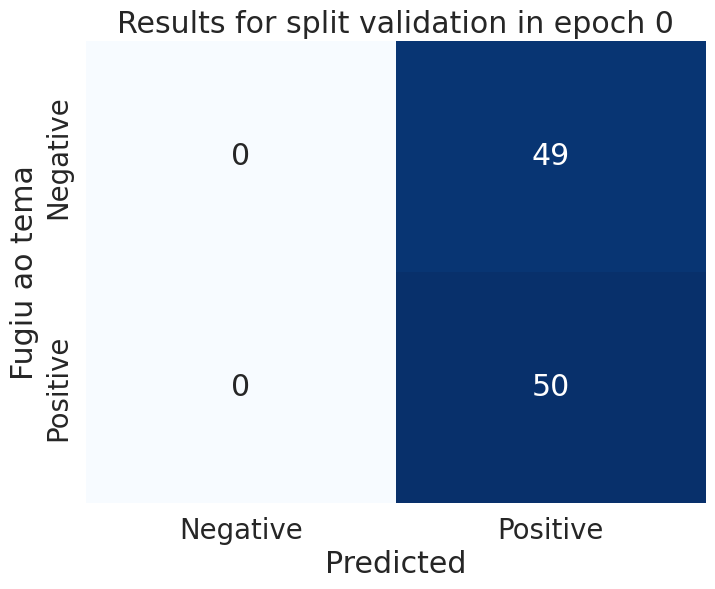

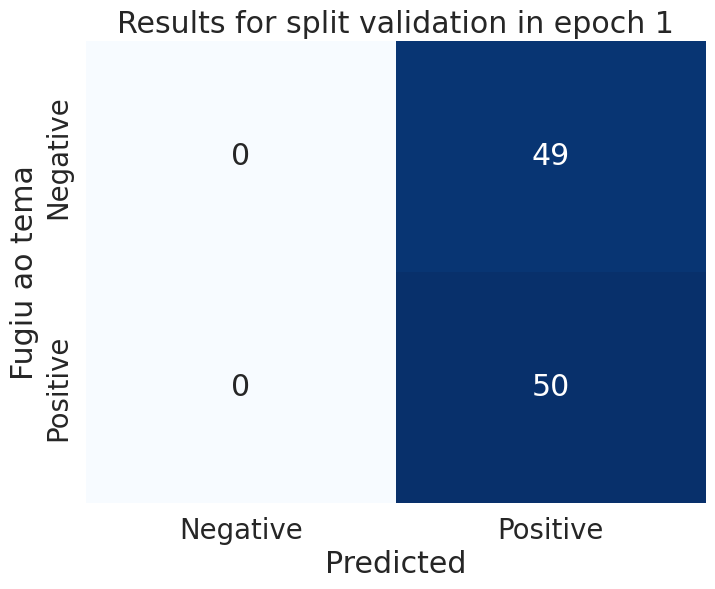

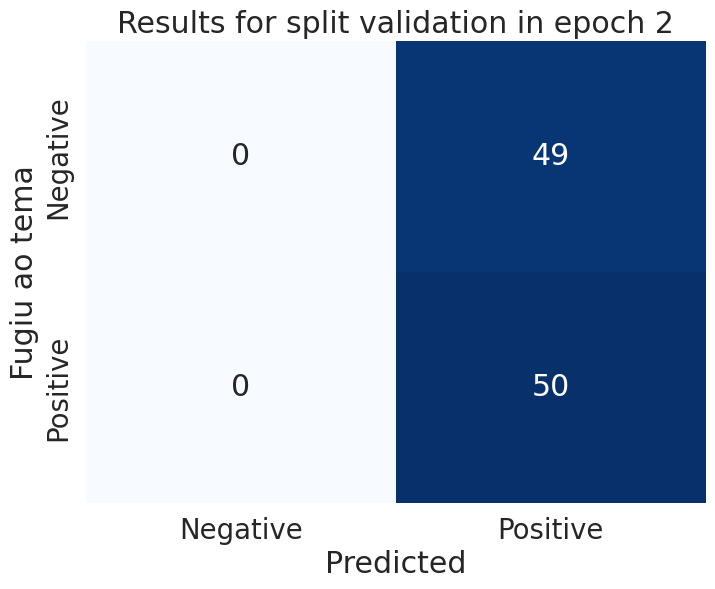

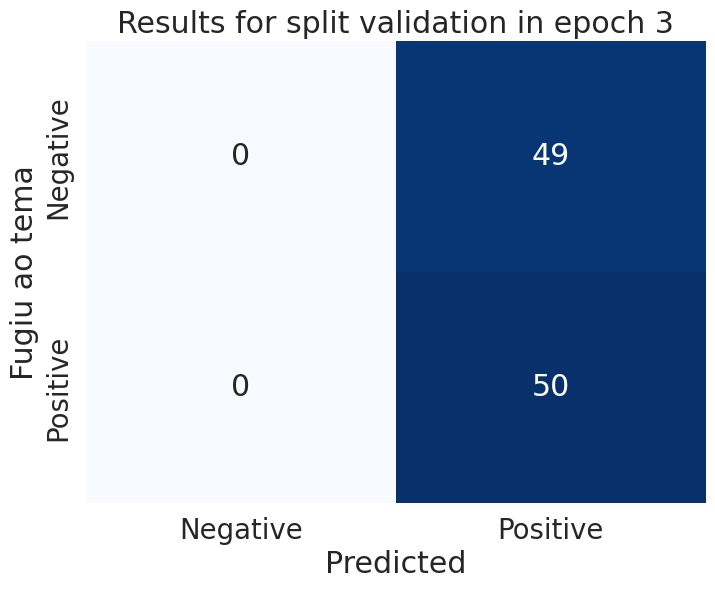

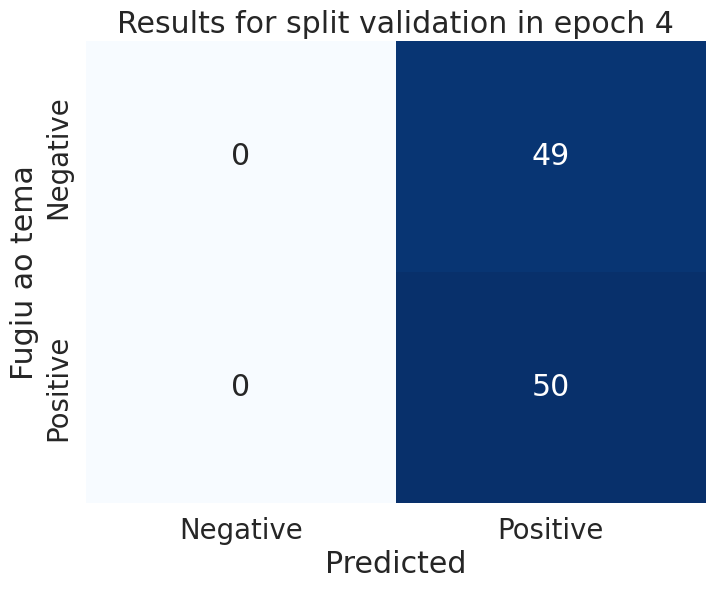

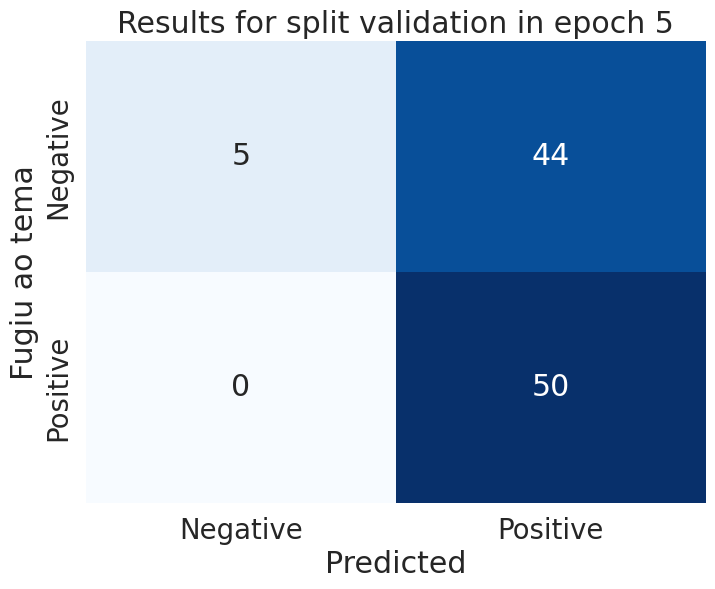

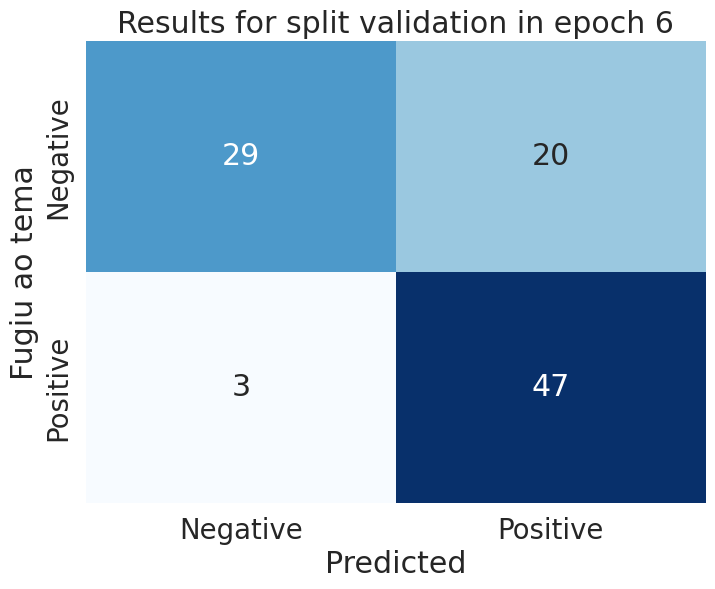

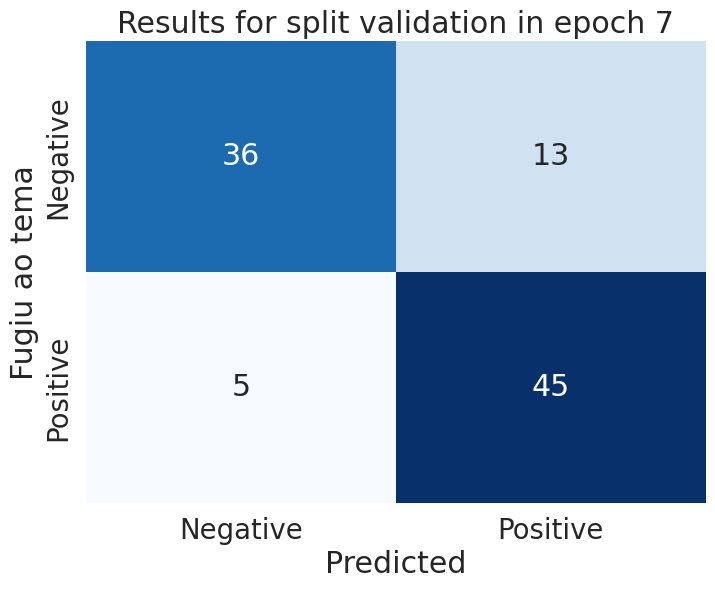

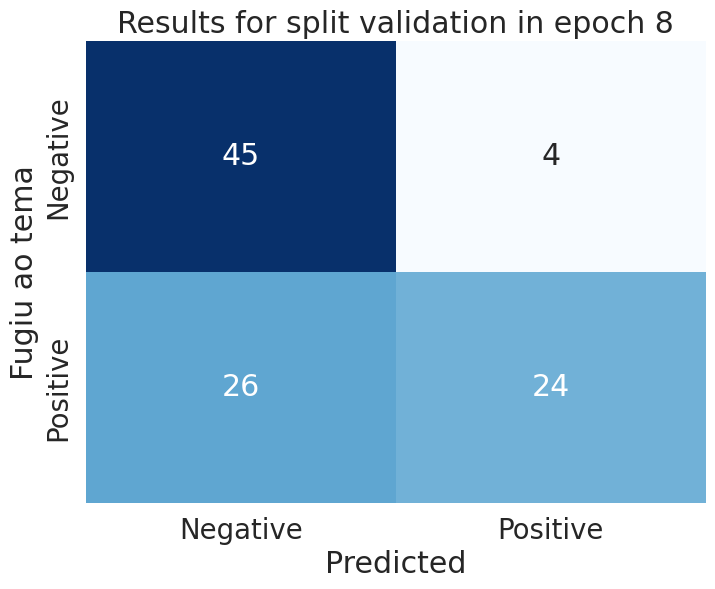

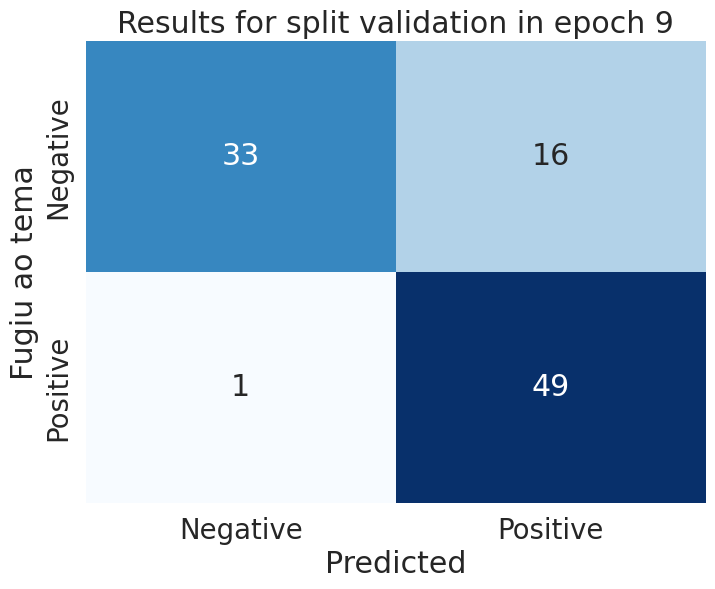

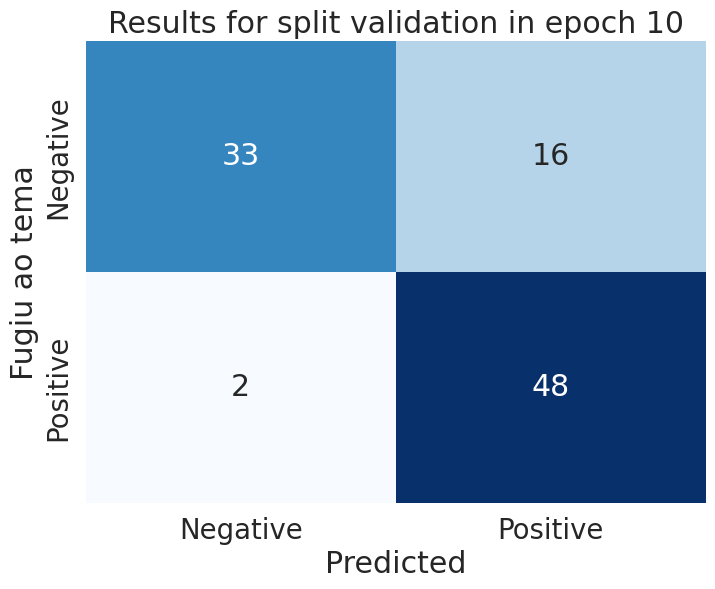

In [11]:
fine_tuner.plot_confusion_matrices("validation")

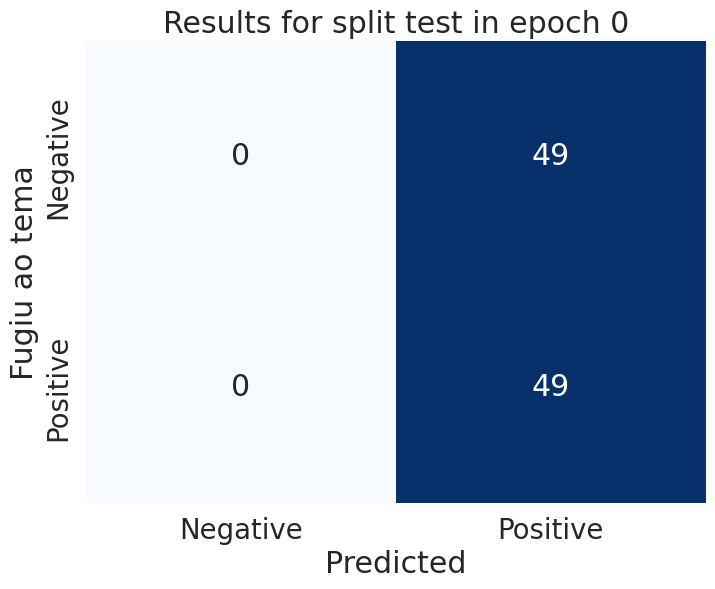

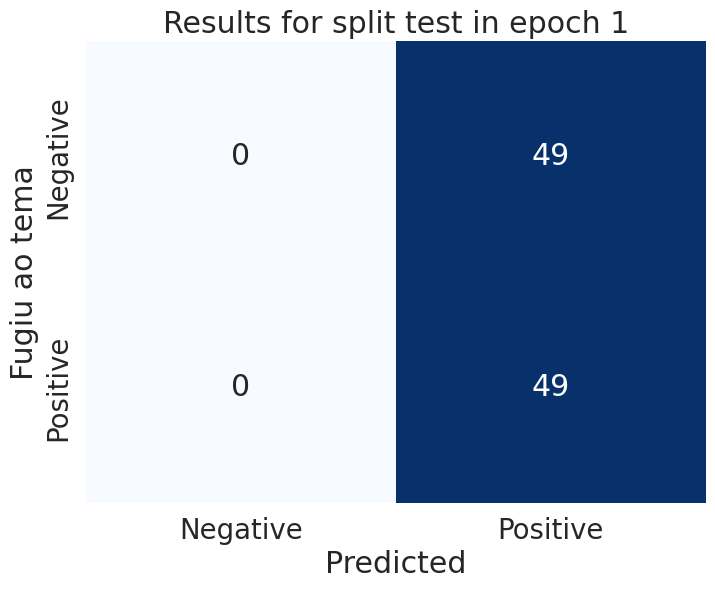

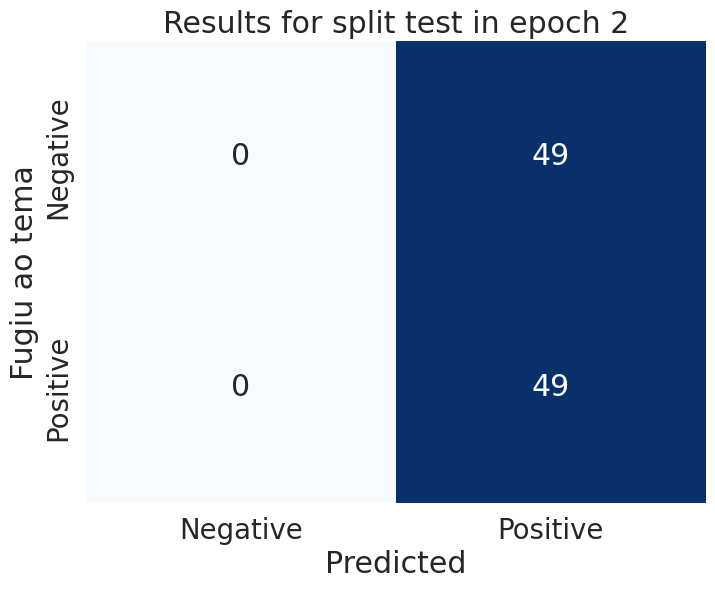

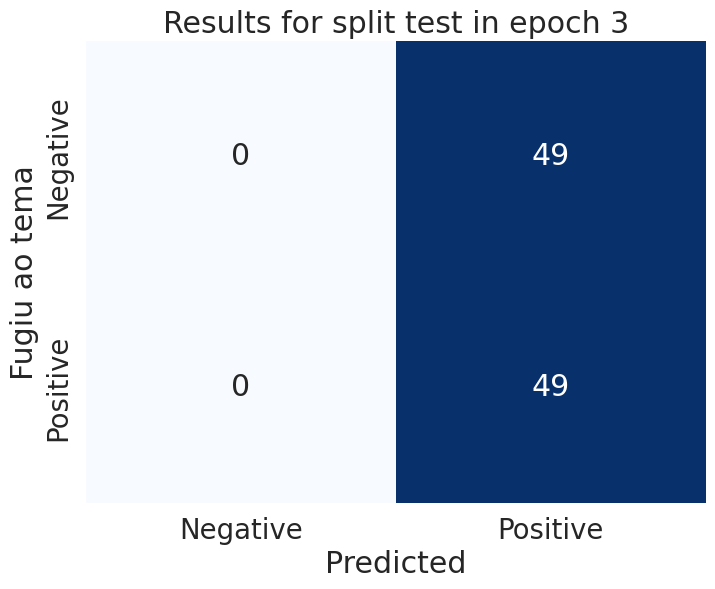

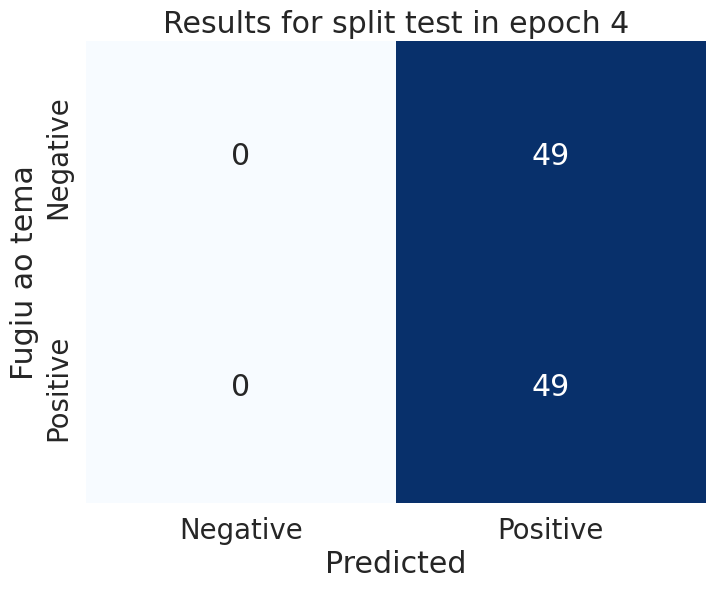

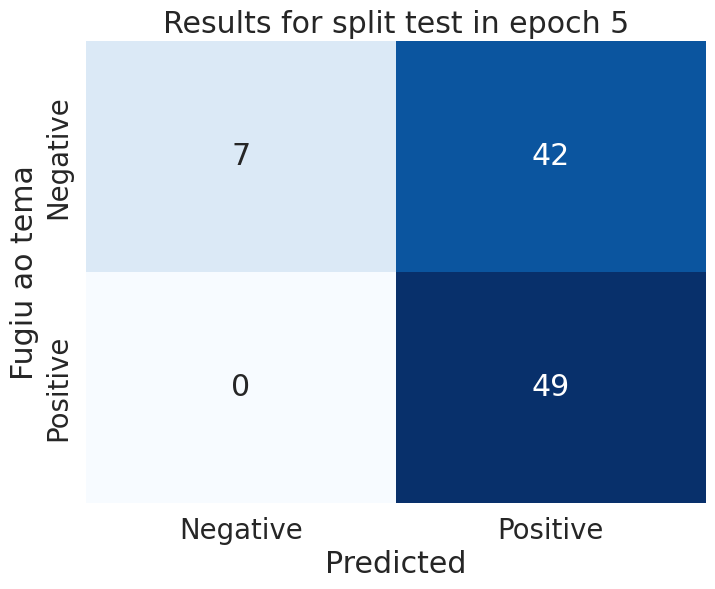

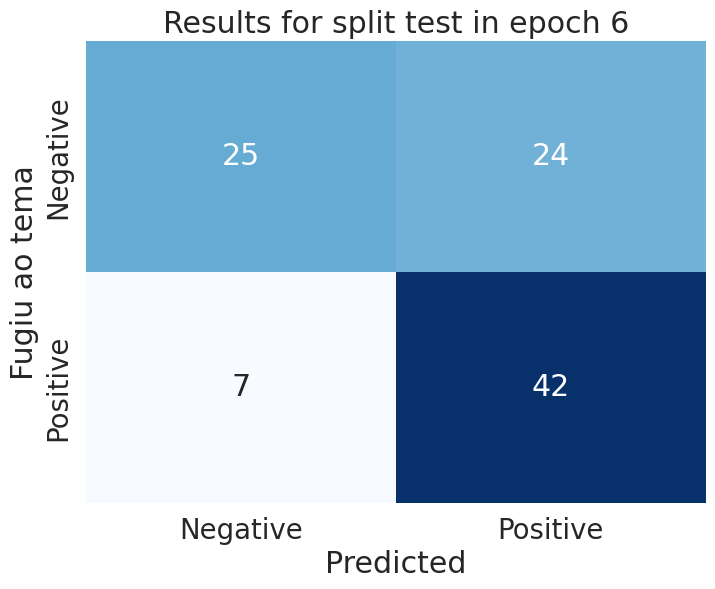

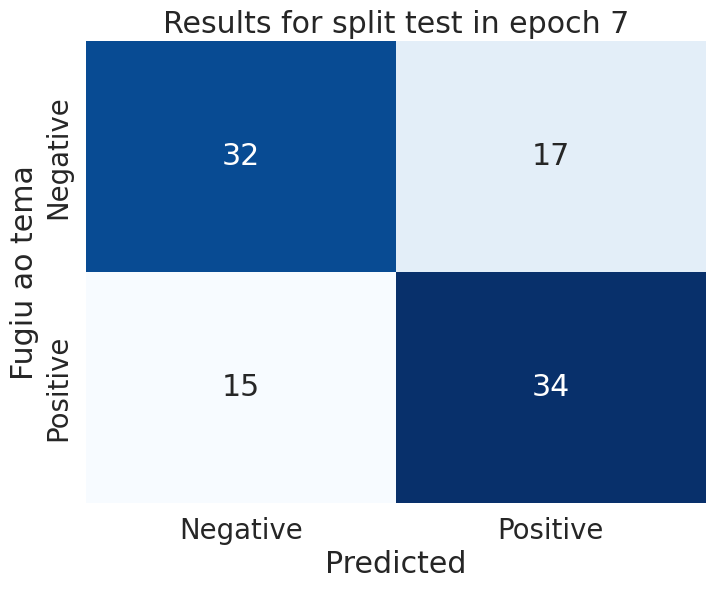

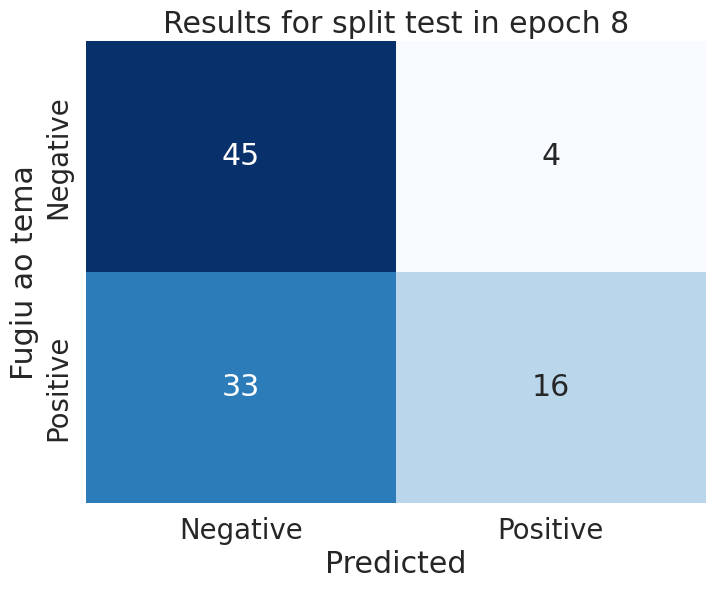

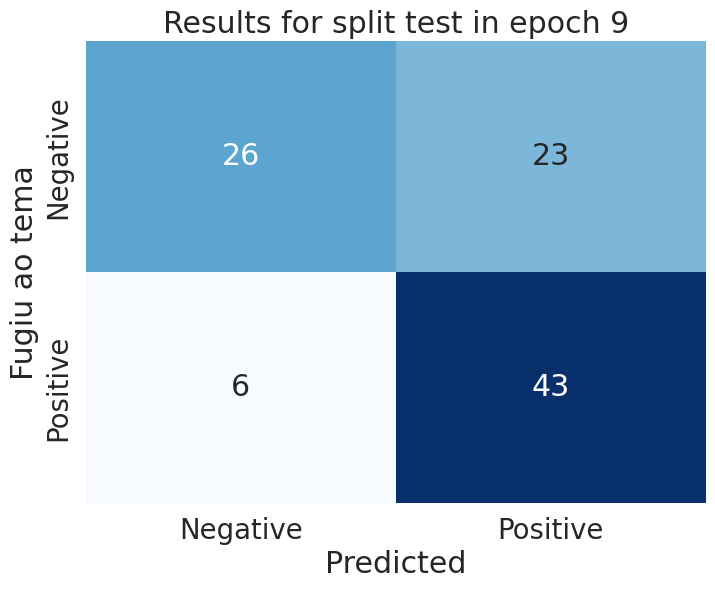

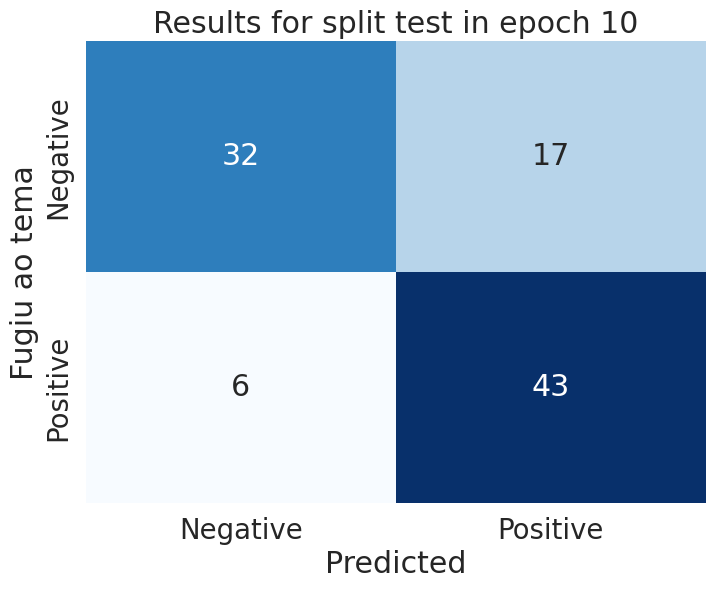

In [12]:
fine_tuner.plot_confusion_matrices("test")